In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Load the CSV file
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import math
from scipy.stats import ttest_ind
from statistics import mean, stdev
from itertools import combinations


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Read the data
file_path = fr"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Updated Results\STSR_Eval_logresults_23-08-24_22-42.csv"
data = pd.read_csv(file_path)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

def calculate_srm(col1, col2):
    valid_indices = ~col1.isna() & ~col2.isna()
    if np.any(valid_indices):
        mean_diff = np.mean(col1[valid_indices] - col2[valid_indices])
        std_diff = np.std((col1[valid_indices] - col2[valid_indices]), ddof=1)
        return mean_diff / std_diff
    else:
        return np.nan

def calculate_cohens_d(group1, group2):
    mean_diff = mean(group1) - mean(group2)
    pooled_std = np.sqrt((stdev(group1)**2 + stdev(group2)**2) / 2)
    return mean_diff / pooled_std

# Function to plot scatter plots
def plot_scatter(data, sensor):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"

    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    
    algorithms = list(data['Algorithm'].unique())
    
    #Makes sure it is the last one 
    if "HMM-SM" in algorithms:
        algorithms.remove("HMM-SM")
        algorithms.append("HMM-SM")
        
    colorslist = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = [colorslist[i % len(colorslist)] for i in range(11)]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure for subplots
    
    for idx, algorithm in enumerate(algorithms):
        subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
        df = pd.DataFrame(columns=['L0', 'L1', 'L2'], index=range(len(subset['Participant'].unique())))
        df_ydiff = pd.DataFrame(columns=['L0', 'L1', 'L2'], index=range(len(subset['Participant'].unique())))
        if not subset.empty:
            ax = axs[idx]
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.axhline(y=0,linestyle='--',linewidth=1,color='k')
            for i, participant in enumerate(subset['Participant'].unique()):
                participant_data = subset[subset['Participant'] == participant].copy()
                if algorithm == "HMM-SM":
                    participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
                Y = participant_data['Y']
                participant_data['Y_diff'] = participant_data['Y'] - participant_data['Y'].iloc[0]
                Y_diff = participant_data['Y_diff'].values.tolist()
                df.loc[i] = Y
                
                df_ydiff.loc[i] = Y_diff
                ax.plot(['0', '0.03', '0.06'], Y_diff, label=f"P{i+1}")
                ax.scatter(['0', '0.03', '0.06'], Y_diff, marker='o', edgecolors=colors[i], facecolors='none')
                #ax.set_ylim(bottom=0)
            ax.set_xlabel("Δ STSR", fontsize=24)
            ax.tick_params(axis='both', which='major', labelsize=24)
            if idx == 0:
                ax.set_ylabel("Δ Similarity Score", fontsize=24)  # Only on the leftmost plot
            ax.set_title(f"{algorithm} - Sensor: {sensor_titles[sensor]}", fontsize=24, fontweight='bold')
            print(f"{algorithm},{sensor}")
            print(df_ydiff)
    # Single legend outside the plot, but closer to the subplots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.95, 0.5), title="Participants",fontsize=18,title_fontsize=24)
    
    # Adjust the layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust rect to leave space for the title and legend
    
    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    #plt.suptitle(f"Sensor: {sensor_titles[sensor]}", x=0.5,y=1, fontsize=18)  # Larger sensor title, not bold
    directory, filename = os.path.split(file_path)
    basename, ext = os.path.splitext(filename)
    image_filename = f"{basename}_{sensor}.svg"
    image_file_path = os.path.join(directory, image_filename)
    plt.savefig(image_file_path)
    print(image_file_path)
    #plt.savefig(fr"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Results\STSR\logresults_16-08-24_23-07_{sensor}_Scatter_STSR.svg", bbox_inches='tight')
    plt.show()

# Function to plot error bar plots
def plot_error_bars(data, sensor):
    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    algorithms = list(data['Algorithm'].unique())
    
    #fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure for subplots
    
    for idx, algorithm in enumerate(algorithms):
        subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
        df = pd.DataFrame(columns=['L0', 'L1', 'L2'], index=range(len(subset['Participant'].unique())))
        
        if not subset.empty:
            ax = axs[idx]
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            for i, participant in enumerate(subset['Participant'].unique()):
                participant_data = subset[subset['Participant'] == participant].copy()
                if algorithm == "HMM-SM":
                    participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
                Y = participant_data['Y']
                df.loc[i] = Y
                
            #print(df)
            mean_values = df.mean()
            #print(mean_values)
            sem_values = df.sem()
            x_labels = df.columns
            ax.errorbar(['0', '0.4', '0.8'], mean_values[1:], yerr=1.96 * sem_values[1:], fmt='o', capsize=5, color='black')
            ax.set_xlabel('Δ GPS', fontsize=14)
            ax.set_xticklabels()
            if idx == 0:
                ax.set_ylabel('Similarity', fontsize=14)  # Only on the leftmost plot
            ax.set_title(f"{algorithm} - Sensor: {sensor_titles[sensor]}", fontsize=14, fontweight='bold')
    
    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    #plt.suptitle(f"Sensor: {sensor_titles[sensor]}", x=0.5,y=1, fontsize=18)  # Larger sensor title, not bold
    directory, filename = os.path.split(file_path)
    basename, ext = os.path.splitext(filename)
    image_filename = f"{basename}_{sensor}_{algorithm}.svg"
    image_file_path = os.path.join(directory, image_filename)
    plt.savefig(image_file_path)
    print(image_file_path)
    #plt.savefig(f"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Results\GPS\logresults_16-08-24_18-14_GPS_{sensor}_ErrorBars_GPS.svg", bbox_inches='tight')
    plt.show()

sensors = data['Sensor'].unique()
Algorithms = data['Algorithm'].unique()
# Plot for each sensor across all algorithms
for sensor in sensors:
    plot_scatter(data, sensor)
    #plot_error_bars(data, sensor)

FileNotFoundError: [Errno 2] No such file or directory: 'Q:\\main_propellab\\Users\\Ng, Gabe\\Summer Student 2024\\Manuscript\\Updated Results\\STSR_Eval_logresults_23-08-24_22-42.csv'

TypeError: Axes.errorbar() missing 1 required positional argument: 'y'

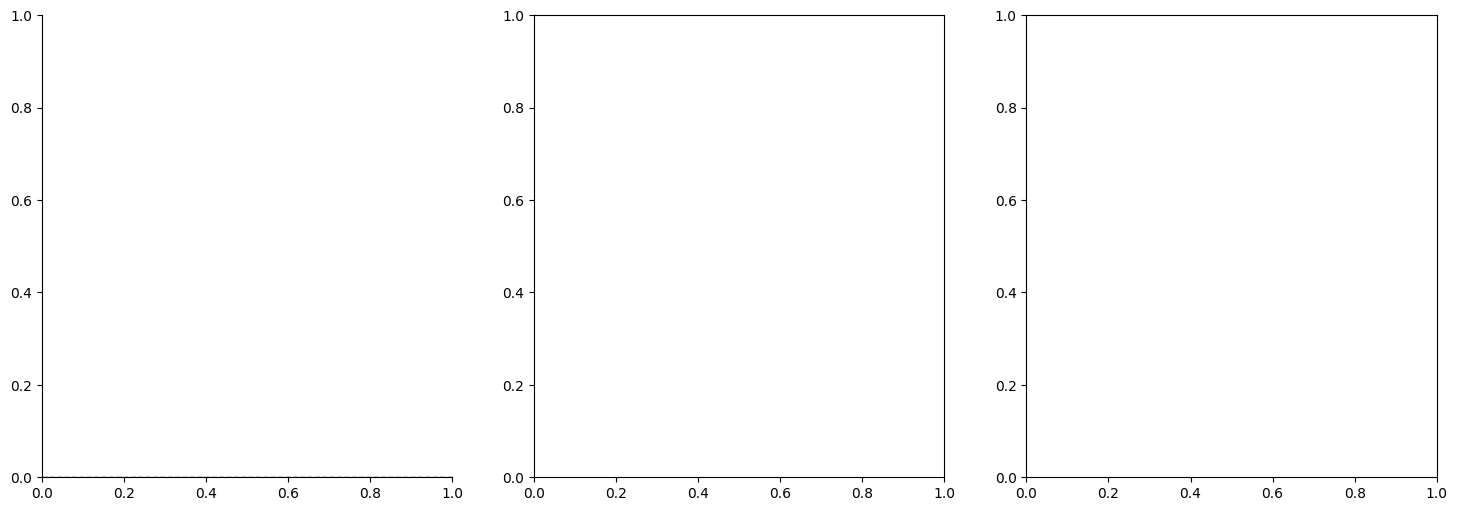

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Read the data
file_path = fr"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Updated Results\PT_Eval_logresults_23-08-24_18-06.csv"
data = pd.read_csv(file_path)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')


# Function to plot scatter plots
def plot_scatter(data, sensor):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"

    sensor_titles = {'Upper': 'Upper Leg', 'Lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    
    algorithms = list(data['Algorithm'].unique())
    
    #Makes sure it is the last one 
    if "HMM-SM" in algorithms:
        algorithms.remove("HMM-SM")
        algorithms.append("HMM-SM")
        
    colorslist = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = [colorslist[i % len(colorslist)] for i in range(12)]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure for subplots
    
    for idx, algorithm in enumerate(algorithms):
        subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
        df = pd.DataFrame(columns=['Pre-PT', 'Post-PT'], index=range(len(subset['Participant'].unique())))
        df_ydiff = pd.DataFrame(columns=['Pre-PT', 'Post-PT'], index=range(len(subset['Participant'].unique())))
        if not subset.empty:
            ax = axs[idx]
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.axhline(y=0,linestyle='--',linewidth=1,color='k')
            for i, participant in enumerate(subset['Participant'].unique()):
                participant_data = subset[subset['Participant'] == participant].copy()
                if algorithm == "HMM-SM":
                    participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
                Y = participant_data['Y'].values.tolist()
                participant_data['Y_diff'] = participant_data['Y'] - participant_data['Y'].iloc[0]
                Y_diff = participant_data['Y_diff'].values.tolist()
                df.loc[i] = Y
                
                df_ydiff.loc[i] = Y_diff
                ax.plot(['Pre-PT', 'Post-PT'], Y_diff, label=f"P{i+1}")
                ax.scatter(['Pre-PT', 'Post-PT'], Y_diff, marker='o', edgecolors=colors[i], facecolors='none')
                #ax.set_ylim(bottom=0)
            #ax.set_xlabel("Δ STSR", fontsize=24)
            ax.tick_params(axis='both', which='major', labelsize=24)
            if idx == 0:
                ax.set_ylabel("Δ Similarity Score", fontsize=24)  # Only on the leftmost plot
            ax.set_title(f"{algorithm} - Sensor: {sensor_titles[sensor]}", fontsize=24, fontweight='bold')
            print(f"{algorithm},{sensor}")
            print(df_ydiff)
    # Single legend outside the plot, but closer to the subplots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.95, 0.5), title="Participants",fontsize=18, title_fontsize=24)
    
    # Adjust the layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust rect to leave space for the title and legend
    
    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    #plt.suptitle(f"Sensor: {sensor_titles[sensor]}", x=0.5,y=1, fontsize=18)  # Larger sensor title, not bold
    directory, filename = os.path.split(file_path)
    basename, ext = os.path.splitext(filename)
    image_filename = f"{basename}_{sensor}.svg"
    image_file_path = os.path.join(directory, image_filename)
    plt.savefig(image_file_path)
    print(image_file_path)
    #plt.savefig(fr"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Results\STSR\logresults_16-08-24_23-07_{sensor}_Scatter_STSR.svg", bbox_inches='tight')
    plt.show()

def plot_error_bars(data, sensor):
    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    algorithms = list(data['Algorithm'].unique())
    
    #fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure for subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure for subplots
    for idx, algorithm in enumerate(algorithms):
        subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
        df = pd.DataFrame(columns=['Pre-PT', 'Post-PT'], index=range(len(subset['Participant'].unique())))
        df_ydiff = pd.DataFrame(columns=['Pre-PT', 'Post-PT'], index=range(len(subset['Participant'].unique())))
        if not subset.empty:
            ax = axs[idx]
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.axhline(y=0,linestyle='--',linewidth=1,color='k')
            for i, participant in enumerate(subset['Participant'].unique()):
                participant_data = subset[subset['Participant'] == participant].copy()
                if algorithm == "HMM-SM":
                    participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
                Y = participant_data['Y'].values.tolist()
                participant_data['Y_diff'] = participant_data['Y'] - participant_data['Y'].iloc[0]
                Y_diff = participant_data['Y_diff'].values.tolist()
                df.loc[i] = Y
                
                df_ydiff.loc[i] = Y_diff
                
            #print(df)
            mean_values = df.mean()
            #print(mean_values)
            sem_values = df.sem()
            x_labels = df.columns
            ax.errorbar(mean_values[1:], yerr=1.96 * sem_values[1:], fmt='o', capsize=5, color='black')
            ax.set_xlabel('Δ GPS', fontsize=14)
            ax.set_xticklabels()
            if idx == 0:
                ax.set_ylabel('Similarity', fontsize=14)  # Only on the leftmost plot
            ax.set_title(f"{algorithm} - Sensor: {sensor_titles[sensor]}", fontsize=14, fontweight='bold')
            
                
sensors = data['Sensor'].unique()
Algorithms = data['Algorithm'].unique()
# Plot for each sensor across all algorithms
for sensor in sensors:
    #plot_scatter(data, sensor)
    plot_error_bars(data, sensor)

In [7]:
""" T-test, benjamini-hochberg correction and SRM for each comparison level"""
import numpy as np
import pandas as pd
import pingouin as pg
import os
from itertools import combinations

# Function to calculate SRM
def calculate_srm(data1, data2):
    difference = data1 - data2
    mean_diff = np.mean(difference)
    std_diff = np.std(difference, ddof=1)
    return mean_diff / std_diff if std_diff != 0 else np.nan

# Reading the data
file_path = r"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Updated Results\STSR_Eval_logresults_23-08-24_22-42.csv"
#data = pd.read_csv(file_path, header=None)
data = pd.read_csv(file_path)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')
data['X'] = pd.to_numeric(data['X'], errors='coerce')

def analysis_byalgorithm(data, algorithm, sensor, parametric=True, correction='fdr_bh'):
    subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
    print(f'Generating results for {algorithm}, {sensor}, number of data points: {len(subset)}')
    levels = ['L0','L1','L2']
    #levels = ['Pre-Rehab','Post-Rehab']
    df = pd.DataFrame(columns=levels, index=range(len(data['Participant'].unique())))  # Initialize outside the loop
    
    if not subset.empty:
        for i, participant in enumerate(subset['Participant'].unique()):
            participant_data = subset[subset['Participant'] == participant].copy()
            if algorithm == "HMM-SM":
                participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
            Y = participant_data['Y'].values.tolist()
            X = participant_data['X'].values.tolist()
            df.loc[i] = Y

    df.dropna(inplace=True)

    if df.empty:
        print("No complete data available for pairwise comparisons.")
        return
    print(df)
    
    #Melts the data so that pre rehab and post rehab end up on the same column together (specified by level)
    df_melted = df.reset_index().melt(id_vars=['index'], var_name='Level', value_name='Y')
    df_melted.rename(columns={'index': 'Participant'}, inplace=True)
    df_melted['Y'] = pd.to_numeric(df_melted['Y'], errors='coerce')
    df_melted.dropna(subset=['Y'], inplace=True)

    
    results = pg.pairwise_tests(
        dv='Y', 
        within='Level', 
        subject='Participant', 
        data=df_melted, 
        parametric=parametric, 
        padjust=correction, 
        effsize='cohen'
    )

    # Calculate SRM for each comparison
    srm_values = {}
    normality = {}
    #levels = ['Pre-Rehab', 'Post-Rehab']
    pairs = list(combinations(levels, 2))
    for level1, level2 in pairs:
        data1 = df[df.columns[df.columns.get_loc(level1)]].astype(float)
        data2 = df[df.columns[df.columns.get_loc(level2)]].astype(float)
        
        if not data1.empty and not data2.empty:
            difference = data1 - data2
            mean_diff = np.mean(difference)
            std_diff = np.std(difference, ddof=1)
            srm =  mean_diff / std_diff if std_diff != 0 else np.nan
            srm_values[f'{level1}_vs_{level2}'] = srm
            
            normality_res = pg.normality(difference)
            p_normality = normality_res['pval'].values[0]
            normality_value = True if p_normality > 0.05 else p_normality
            normality[f'{level1}_vs_{level2}'] = normality_value
        else:
            print(f"Data for {level1} or {level2} is empty.")
            srm_values[f'{level1}_vs_{level2}'] = np.nan

    results['Sensor'] = sensor
    results['Algorithm'] = algorithm
    
    if len(pairs) == 1:
        # Directly assign the SRM and Normality if there is only one comparison pair
        comparison_key = f'{pairs[0][0]}_vs_{pairs[0][1]}'
        results['SRM'] = srm_values.get(comparison_key, np.nan)
        results['Normality'] = normality.get(comparison_key, np.nan)
    else:
        # Use apply for multiple comparison pairs
        results['SRM'] = results.apply(lambda row: srm_values.get(f'{row["A"]}_vs_{row["B"]}', np.nan), axis=1)
        results['Normality'] = results.apply(lambda row: normality.get(f'{row["A"]}_vs_{row["B"]}', np.nan), axis=1)

    # Reorder columns to make 'Sensor' and 'Algorithm' the leftmost columns
    results = results[['Sensor', 'Algorithm'] + [col for col in results.columns if col not in ['Sensor', 'Algorithm']]]


    directory, filename = os.path.split(file_path)
    basename, ext = os.path.splitext(filename)
    new_filename = f"{basename}_statistics{ext}"

    output_file_path = os.path.join(directory, new_filename)
    if not os.path.exists(output_file_path):
        results.to_csv(output_file_path, index=False)
    else:
        results.to_csv(output_file_path, mode='a', header=False, index=False)

    print(f"Results appended to {output_file_path}")

# Get unique combinations of sensors and algorithms
sensors = data['Sensor'].unique()
algorithms = data['Algorithm'].unique()

# Perform analysis for each combination of sensor and algorithm
for sensor in sensors:
    for algorithm in algorithms:
        analysis_byalgorithm(data, algorithm, sensor, parametric=True, correction='fdr_bh')  # Set parametric to True or False as needed

Generating results for DTW, pelvis, number of data points: 33
           L0         L1         L2
0    9.850061   9.562258   9.900746
1    9.649492   9.572687   9.436689
2    9.059915   9.092615   8.996208
3     9.98863   9.963594  10.101557
4   10.113901  10.159709  10.266025
5    9.768471    9.79241   9.826966
6   10.166858  10.230491  10.184844
7    8.596195   8.580016   9.110353
8   10.163189  10.057382   9.994269
9    8.104466   8.272606   8.202781
10   9.668853    9.58184    9.60198
Results appended to Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Updated Results\STSR_Eval_logresults_23-08-24_22-42_statistics.csv
Generating results for MDP, pelvis, number of data points: 33
          L0        L1        L2
0   0.711749  0.691289  0.734677
1   0.735662   0.72239  0.700773
2   0.689064  0.694711  0.684108
3   0.702704  0.701644  0.716951
4    0.70511  0.728784  0.751225
5   0.725904  0.721529   0.72293
6   0.700462  0.707382  0.706839
7   0.634114  0.642753  0.721

Generating results for DTW, pelvis, number of data points: 24
0     0.114681
1     1.056996
2     2.430272
3     1.817217
4     3.547427
5     4.248493
6     0.138192
7     3.874825
8     2.671147
9     1.477076
10    2.581805
11    1.082628
Name: Δ Similarity, dtype: float64
Generating results for MDP, pelvis, number of data points: 24
0     0.036669
1     0.082253
2     0.245714
3     0.172736
4     0.386048
5     0.420326
6     0.067244
7     0.440000
8     0.304712
9     0.222984
10    0.215954
11    0.121113
Name: Δ Similarity, dtype: float64
Generating results for HMM-SM, pelvis, number of data points: 36
0    -0.255114
1    -0.058086
2    -0.272921
3    -0.110306
4    -0.048914
5    -0.080378
6    -0.058102
7    -0.300723
8    -0.055830
9     0.099888
10   -0.169085
11   -0.001189
Name: Δ Similarity, dtype: float64
Generating results for DTW, Upper, number of data points: 24
0     1.775718
1     1.844684
2     3.076191
3     2.301501
4     2.943015
5     3.771197
6     0.647893


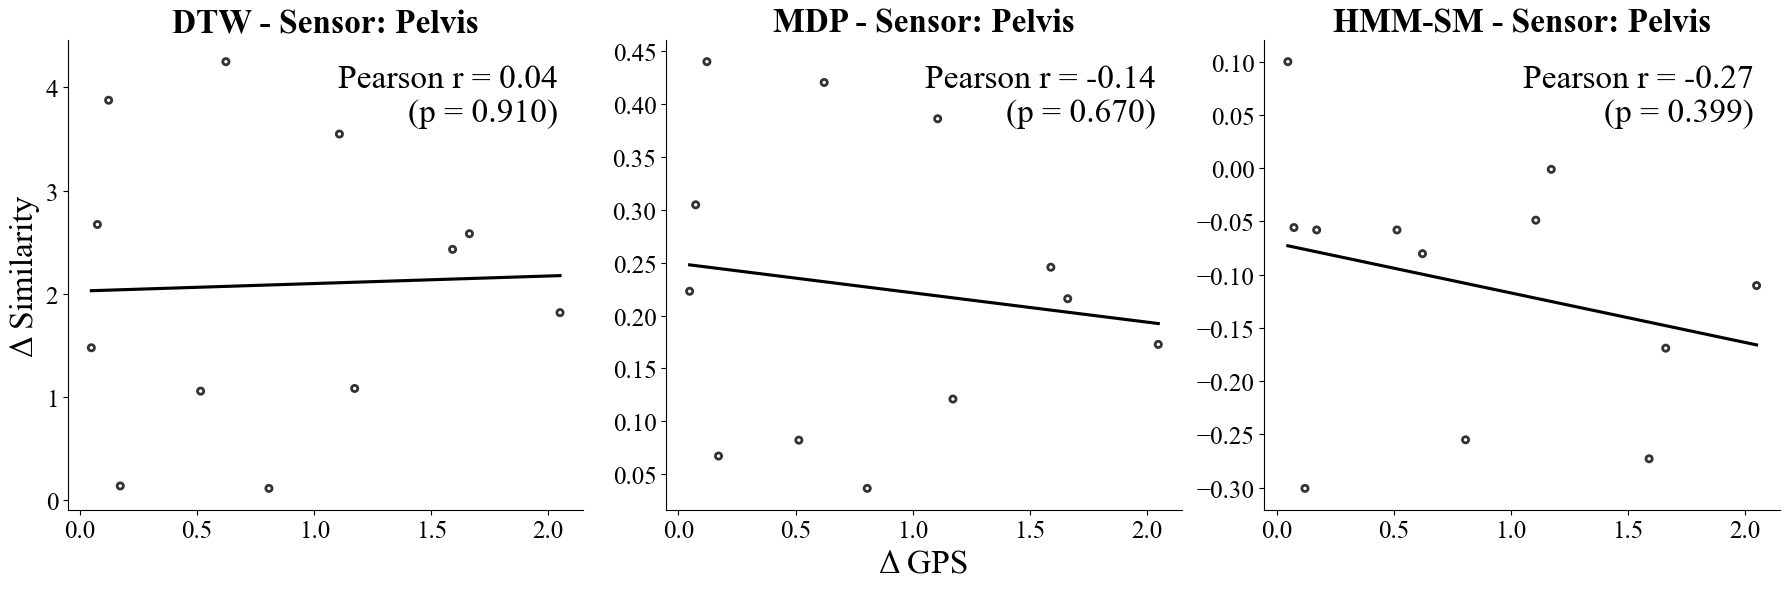

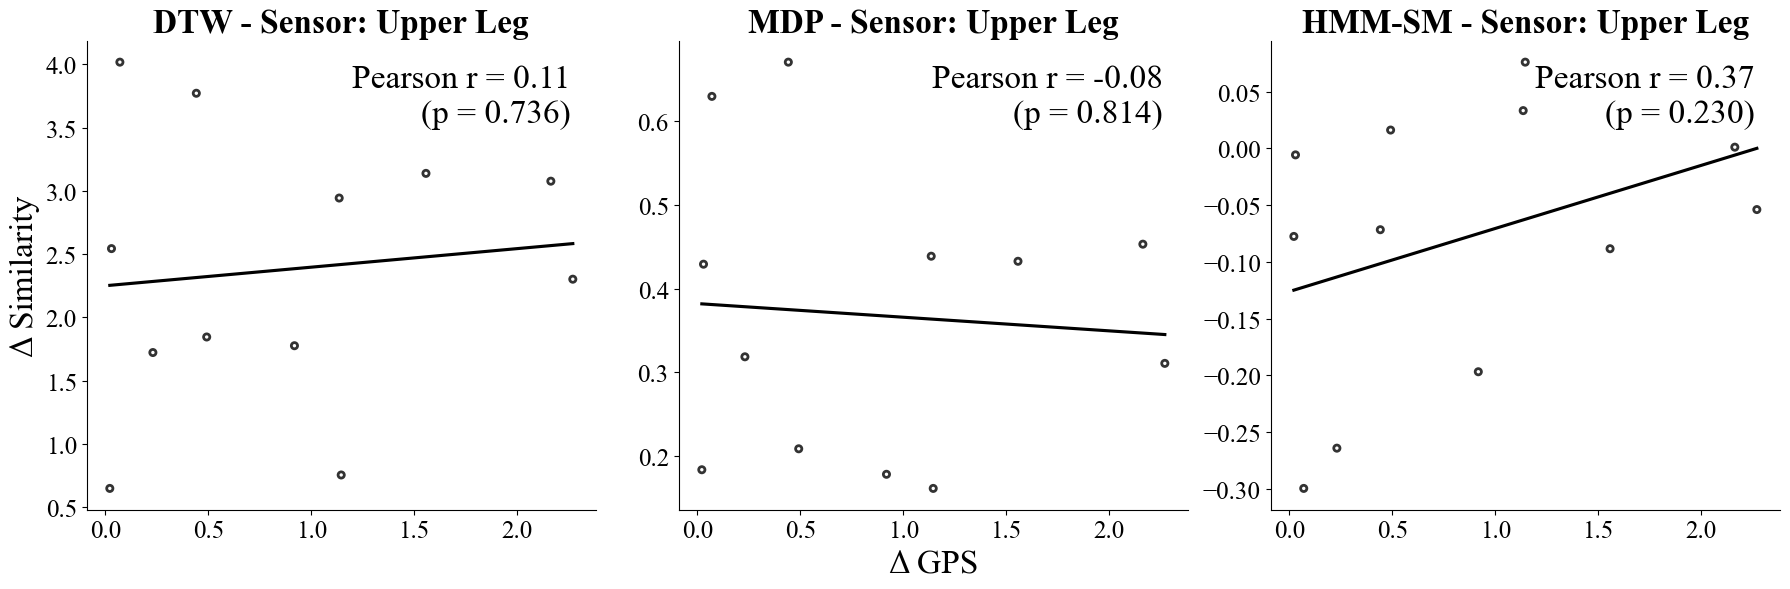

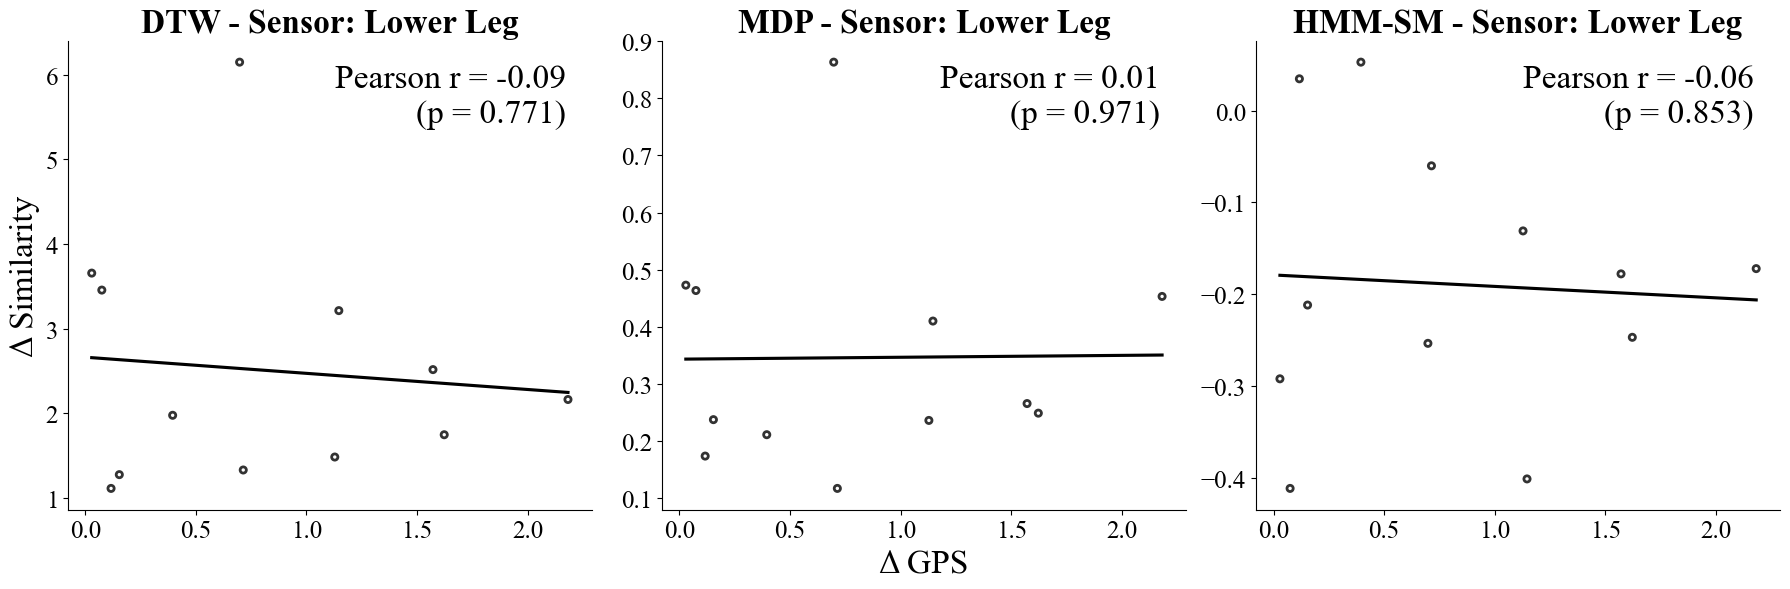

In [30]:
import numpy as np
import pandas as pd
import pingouin as pg
import os
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from csv import writer


def calculate_srm(data1, data2):
    difference = data1 - data2
    mean_diff = np.mean(difference)
    std_diff = np.std(difference, ddof=1)
    return mean_diff / std_diff if std_diff != 0 else np.nan

file_path = r"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Updated Results\PT Results\PT_Eval_logresults_23-08-24_18-06.csv"
directory, filename = os.path.split(file_path)
basename, ext = os.path.splitext(filename)
#data = pd.read_csv(file_path, header=None)
data = pd.read_csv(file_path)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')
#data['X'] = pd.to_numeric(data['X'], errors='coerce')


def analysis_byalgorithm(data, algorithms, sensor, parametric=True, correction='fdr_bh'):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure for subplots
    for idx, algorithm in enumerate(algorithms):
        subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
        print(f'Generating results for {algorithm}, {sensor}, number of data points: {len(subset)}')

        df = pd.DataFrame(columns=['Pre-Rehab','Post-Rehab'], index=range(len(data['Participant'].unique())))  # Initialize outside the loop
        df_difference = pd.DataFrame(columns=['Δ GPS','Δ Similarity'], index=range(len(data['Participant'].unique())))
        if not subset.empty:
            GPS = []
            Deviation_score = []
            for i, participant in enumerate(subset['Participant'].unique()):
                participant_data = subset[subset['Participant'] == participant].copy()
                if algorithm == "HMM-SM":
                    baseline_GPS = participant_data['X'].apply(lambda x: float(x.split('-')[0].strip()) if isinstance(x, str) else x)
                    participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
                    participant_data['X'] = participant_data['X'].apply(lambda x: float(x.split('-')[1].strip()) if isinstance(x, str) else x)
                    
                
                participant_data['X'] = pd.to_numeric(participant_data['X'], errors='coerce')
                Y = participant_data['Y'].values.tolist()
                X = participant_data['X'].values.tolist()
                df.loc[i] = Y
                participant_data['Y_diff'] =  participant_data['Y'].iloc[1] -  participant_data['Y'].iloc[0]
                participant_data['X_diff'] =  participant_data['X'].iloc[1] - participant_data['X'].iloc[0]
                participant_data['X_diff'] = participant_data['X_diff'].abs()
                Y_diff = participant_data['Y_diff'].values.tolist()
                X_diff = participant_data['X_diff'].values.tolist()
                
                df_difference.at[i, 'Δ GPS'] = participant_data['X_diff'].iloc[0]
                df_difference.at[i, 'Δ Similarity'] = participant_data['Y_diff'].iloc[0]
                df_difference['Δ GPS'] = pd.to_numeric(df_difference['Δ GPS'], errors='coerce')
                df_difference['Δ Similarity'] = pd.to_numeric(df_difference['Δ Similarity'], errors='coerce')
        
            print(df_difference['Δ Similarity'])
            
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False
        plt.rcParams["font.family"] = "serif"
        plt.rcParams["font.serif"] = "Times New Roman"
       
        ax = axs[idx]

            
        ax.tick_params(axis='both', which='major', labelsize=18)
        
        sensor_titles = {'Upper': 'Upper Leg', 'Lower': 'Lower Leg', 'pelvis': 'Pelvis'}
        sns.regplot(data=df_difference, x=df_difference['Δ GPS'], y=df_difference['Δ Similarity'],ci=None,color='black',scatter_kws={'s': 30, 'facecolor': 'None', 'linewidths': 2}, ax= ax).set_title(f"{algorithm} - Sensor: {sensor_titles[sensor]}",fontweight='bold',fontsize=24)
        
        if idx == 0:
            ax.set_ylabel('Δ Similarity', fontsize=18)
        else:
            ax.set_ylabel('')

        # Set the x-axis label only for the bottom plot (last plot in the row)
        if idx == 1:
            ax.set_xlabel('Δ GPS', fontsize=18)
        else:
            ax.set_xlabel('')
        
        ax.xaxis.label.set_size(24)
        ax.yaxis.label.set_size(24)
        r_value, p_value = pearsonr(df_difference['Δ GPS'], df_difference['Δ Similarity'])
        
        d = {'sensor': sensor, 'algorithm':algorithm, 'r-value': r_value, 'p_value': p_value}
        results_df = pd.DataFrame(data=d, index=[0])
        ax.text(0.95, 0.95, f'Pearson r = {r_value:.2f}\n(p = {p_value:.3f})',
                transform=ax.transAxes,
                fontsize=24,
                verticalalignment='top',horizontalalignment='right')
        
        directory, filename = os.path.split(file_path)
        basename, ext = os.path.splitext(filename)
        image_filename = f"{basename}_{sensor}.svg"
        image_file_path = os.path.join(directory, image_filename)
        plt.tight_layout()
        fig.savefig(image_file_path)
        
        directory, filename = os.path.split(file_path)
        basename, ext = os.path.splitext(filename)
        new_filename = f"{basename}_pearsonr{ext}"
        output_file_path = os.path.join(directory, new_filename)

    # if not os.path.exists(output_file_path):
    #     results_df.to_csv(output_file_path, index=False)
    # else:
    #     results_df.to_csv(output_file_path, mode='a', header=False, index=False)

sensors = data['Sensor'].unique()
algorithms = data['Algorithm'].unique()

for sensor in sensors:
    analysis_byalgorithm(data, algorithms, sensor, parametric=False, correction='fdr_bh')  # Set parametric to True or False as needed

In [10]:
import pandas as pd

# Load the original CSV file
file = r"C:\GP-WearablesAnalysis\examples\results_groupinfo_STSR_trial.csv"
df = pd.read_csv(file)  # Replace "your_file.csv" with your actual file name

# Function to calculate [Min, Max] for each participant
def calculate_min_max(df):
    participants = df['Participant'].unique()
    min_max_list = []

    for participant in participants:
        # Filter data for the current participant
        participant_data = df[df['Participant'] == participant]
        
        # Calculate min and max
        min_value = participant_data['Min'].min()
        max_value = participant_data['Max'].max()
        
        # Append the result as a dictionary
        min_max_list.append({
            "Participant": participant,
            "Min-Max": f"[{round(min_value,2)}, {round(max_value,2)}]"
        })

    # Create a new DataFrame for the Min-Max table
    min_max_df = pd.DataFrame(min_max_list)
    return min_max_df

# Calculate the [Min, Max] for each participant
min_max_df = calculate_min_max(df)

# Save the new DataFrame to a separate CSV file
min_max_df.to_csv(file, index=False)

print("Min-Max table has been saved to 'min_max_table.csv'.")

Min-Max table has been saved to 'min_max_table.csv'.


In [14]:
import pandas as pd
import pingouin as pg

# Read the CSV file into a DataFrame
file_path = r"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\RAS_PrePostGVS.csv"
df = pd.read_csv(file_path)


# List of parameters
parameters = [
    'pelvic_tilt',
    'pelvic_obliquity',
    'pelvic_rotation',
    'hip_flexion_L',
    'hip_abduction_L',
    'hip_rotation_L',
    'hip_flexion_R',
    'hip_abduction_R',
    'hip_rotation_R',
    'knee_flexion_R',
    'knee_flexion_L',
    'ankle_flexion_R',
    'ankle_flexion_L',
    'foot_progression_R',
    'foot_progression_L'
]


# Create a dictionary to store the results
results = {'Participant': []}
for param in parameters:
    results[param] = []

# Iterate through each participant
for participant in df['Participant'].unique():
    # Filter the data for the current participant
    participant_data = df[df['Participant'] == participant]
    
    # Add participant to results
    results['Participant'].append(participant)
    
    # Perform paired t-tests for each parameter
    for param in parameters:
        # Prepare the data for the paired t-test
        pre_data = participant_data[participant_data['Condition'] == 'Pre'][param]
        post_data = participant_data[participant_data['Condition'] == 'Post'][param]
        
        # Check if both conditions have the same number of observations
        if len(pre_data) == len(post_data):
            # Perform the paired t-test
            print(len(pre_data))
            t_test_result = pg.ttest(pre_data, post_data, paired=True)
            
            # Store the p-value in the results dictionary
            results[param].append(t_test_result['p-val'].values[0])
        else:
            results[param].append(None)  # Handle cases with mismatched sample sizes

# Convert results to DataFrame
results_df = pd.DataFrame(results)
output_path = r"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\ttest_RAS_GVS.csv"
#Save results to a CSV file
results_df.to_csv(output_path, index=False)

# Display the results
print(results_df)

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
   Participant  pelvic_tilt  pelvic_obliquity  pelvic_rotation  hip_flexion_L  \
0     LLPU_P01     0.235976      3.250189e-14     5.838264e-01   4.093132e-01   
1     LLPU_P02     0.416733      1.467503e-10     1.138873e-03   9.078132e-01   
2     LLPU_P03     0.000105      8.347113e-03     5.157566e-09   4.987383e-02   
3     LLPU_P04     0.001105      5.035737e-04     1.535280e-03   3.296150e-01   
4     LLPU_P05     0.000013      1.276686e-03     2.389847e-08   8.018942e-06   
5     LLPU_P06     